In [116]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import MatrixProductFunctions as mp
#import imageio
import os
import cmath
import math
#import qutip as qt
from numba import njit
import matplotlib.animation as animation
%matplotlib inline
from ipywidgets import IntProgress, HTML
from IPython.display import display
import pickle
import matplotlib.gridspec as gridspec
#import ffmpeg

### Формулы метода Рунге-Кутты

$\mathbf{y}^{\prime}=\mathbf{f}(x, \mathbf{y}), \quad \mathbf{y}\left(x_0\right)=\mathbf{y}_0$

$\mathbf{y}_{n+1}=\mathbf{y}_n+\frac{h}{6}\left(\mathbf{k}_1+2 \mathbf{k}_2+2 \mathbf{k}_3+\mathbf{k}_4\right)$

$\begin{aligned}
& \mathbf{k}_1=\mathbf{f}\left(x_n, \mathbf{y}_n\right), \\
& \mathbf{k}_2=\mathbf{f}\left(x_n+\frac{h}{2}, \mathbf{y}_n+\frac{h}{2} \mathbf{k}_1\right), \\
& \mathbf{k}_3=\mathbf{f}\left(x_n+\frac{h}{2}, \mathbf{y}_n+\frac{h}{2} \mathbf{k}_2\right), \\
& \mathbf{k}_4=\mathbf{f}\left(x_n+h, \mathbf{y}_n+h \mathbf{k}_3\right) .
\end{aligned}$

### Уравнение Шредингера

$i\hbar \dfrac{d\psi}{dt} = \hat{H}\psi$

$\dfrac{d\psi}{dt} = -i\hat{H}\psi$


### Адаптация уравнения Шредингера под метод Рунге-Кутты

$\psi_{t+1} = \psi_t + \dfrac{\Delta t}{6}\left(\mathbf{k}_1+2 \mathbf{k}_2+2 \mathbf{k}_3+\mathbf{k}_4\right)$

$k_1 = -i\hat{H}\psi_t$

$k_2 = -i\hat{H}(\psi_t + \dfrac{\Delta t}{2}k_1)$

$k_3 = -i\hat{H}(\psi_t + \dfrac{\Delta t}{2}k_2)$

$k_4 = -i\hat{H}(\psi_t + \Delta tk_3)$

### Рунге-Кутты 4го порядка для задачи сжатия

In [110]:
n = 8
alpha = 1
t_general = 1
steps_number = 50
delta_t = t_general/steps_number
x = np.linspace(-6, 6, 2**n)

In [111]:
operator = mp.mpo_mul_num(mp.mpo_sum(mp.mpo_multiplication(mp.x_mpo(n, x[0], x[1]-x[0]), mp.der_mpo(n, x[1]-x[0])), mp.chislo(n, 0.5)), alpha)

In [112]:
psi_0 = mp.vec_to_mps(mp.squeezed_vacuum(x, 1, 0))
psi_final = mp.vec_to_mps(mp.squeezed_vacuum(x, 1, 1))

In [113]:
def make_squeezing_RK4_step(psi, delta_t, eps = 1e-6, bond_limit = 1000):
    k1 = mp.mps_compression(mp.mpo_x_mps(operator, psi))
    k2 = mp.mps_compression(mp.mpo_x_mps(operator, mp.mps_compression(mp.mps_sum(psi, mp.mps_mul_num(k1, delta_t/2)))))
    k3 = mp.mps_compression(mp.mpo_x_mps(operator, mp.mps_compression(mp.mps_sum(psi, mp.mps_mul_num(k2, delta_t/2)))))
    k4 = mp.mps_compression(mp.mpo_x_mps(operator, mp.mps_compression(mp.mps_sum(psi, mp.mps_mul_num(k3, delta_t)))))
    solution = mp.mps_compression(mp.mps_sum(mp.mps_mul_num(mp.mps_compression(mp.mps_sum(mp.mps_compression(mp.mps_sum(mp.mps_compression(mp.mps_sum(k1, k4)), mp.mps_mul_num(k2, 2))), mp.mps_mul_num(k3, 2))), delta_t/6), psi))
    return solution

In [114]:
set_of_solutions = []
set_of_solutions.append(psi_0)
psi = make_squeezing_RK4_step(psi_0, delta_t, eps=1e-5, bond_limit=60)
set_of_solutions.append(psi)
for i in tqdm(range(steps_number)):
    psi = make_squeezing_RK4_step(psi, delta_t, eps=1e-5, bond_limit=60)
    set_of_solutions.append(psi)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 60.17it/s]


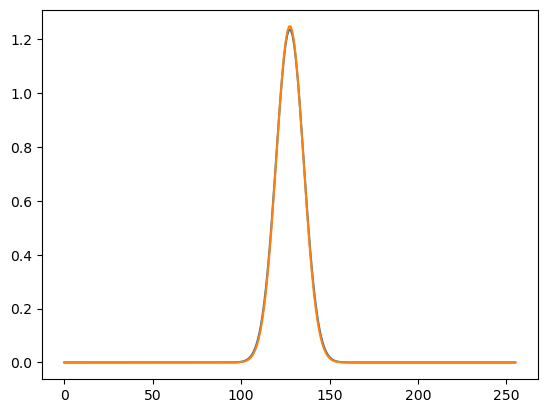

In [115]:
plt.plot(mp.squeezed_vacuum(x, 1, 1))
plt.plot(mp.tensors_multiplication(mp.mps_mul_num(psi, 1)))
plt.show()

### Гамильтониан спонтанного параметрического рассеяния

$\hat{H}_{spdc} = i\hbar \chi^{(2)}(\hat{a}^{\dagger}\hat{b}\hat{b} - \hat{a}\hat{b}^{\dagger}\hat{b}^{\dagger}) =
-i\dfrac{\hbar \chi^{(2)}}{\sqrt{2}}(\dfrac{d}{dx_a}(\hat{x}_b^2 + \dfrac{d^2}{dx_b^2}) - \hat{x}_a(\hat{1}_b + 2\hat{x}_b\dfrac{d}{dx_b}))$

### Параметры 

In [117]:
chi = 1 / 2
theta = 0.001

t_general = 1
steps_number = 20000
delta_t = t_general / steps_number

x_bond1 = 30

x_left = 10 + 2 * 10 * np.sqrt(2)
x_right = 10

x_bond2 = 10
n1 = 10
n2 = 10
x_bias = 10 * np.sqrt(2)
step1 = x_bond1 / 2**(n1 - 1)
step2 = x_bond2 / (2**(n2 - 1))

step1_v1 = (x_left+x_right)/2**n1

eps = 1e-6

sp2 = np.linspace(-10,10,2**n2)
step2 = sp2[1]-sp2[0]

sp1 = np.linspace(-10-10*np.sqrt(2),10+10*np.sqrt(2),2**n1)
step1_v1 = sp1[1]-sp1[0]

### Сборка гамильтониана в коде

#### Операторы для когерентного состояния

In [118]:
coh_operator_one = mp.der_mpo(n1, step1_v1)
coh_operator_two = mp.mpo_mul_num(mp.x_mpo(n1, x_bias - x_left, step1_v1), -1)

#### Операторы для вакуумного состояния

In [119]:
vac_operator_one = mp.mpo_sum(mp.mpo_multiplication(mp.x_mpo(n2, - x_bond2, step2), mp.x_mpo(n2, - x_bond2, step2)), mp.der2_mpo(n2, step2))
vac_operator_two = mp.mpo_sum(mp.one_mpo(n2), mp.mpo_mul_num(mp.mpo_multiplication(mp.x_mpo(n2, - x_bond2, step2), mp.der_mpo(n2, step2)), 2))

#### Процесс сборки

In [120]:
first_part = coh_operator_one + vac_operator_one
second_part = coh_operator_two + vac_operator_two

#### Итоговый гамильтониан

In [121]:
hamiltonian = mp.mpo_mul_num(mp.mpo_sum(first_part, second_part), -chi / (np.sqrt(2)))

#### Итоговый оператор метода Рунге-Кутта

In [122]:
final_operator = mp.mpo_mul_num(hamiltonian, -1j)

### Волновая функия в начальный момент времени

In [123]:
initial_state_mps = mp.asym_gauss_mps(x_left, x_right, n1, 1) + mp.asym_gauss_mps(x_bond2, x_bond2, n2, 1)

### Вычисление коэффициентов $k_1,k_2, k_3, k_4$ 

In [124]:
# k1 = mp.mps_compression(mp.mpo_x_mps(final_operator, initial_state_mps))
# k2 = mp.mps_compression(mp.mpo_x_mps(final_operator, mp.mps_sum(initial_state_mps, mp.mps_mul_num(k1, delta_t/2))))
# k3 = mp.mps_compression(mp.mpo_x_mps(final_operator, mp.mps_sum(initial_state_mps, mp.mps_mul_num(k2, delta_t/2))))
# k4 = mp.mps_compression(mp.mpo_x_mps(final_operator, mp.mps_sum(initial_state_mps, mp.mps_mul_num(k3, delta_t))))

### Вычисление решения на t+1 шаге

$\psi_{t+1} = \psi_t + \dfrac{\Delta t}{6}\left(\mathbf{k}_1+2 \mathbf{k}_2+2 \mathbf{k}_3+\mathbf{k}_4\right)$

In [125]:
def make_SPDC_RK4_step(psi, delta_t, eps = 1e-6, bond_limit = 1000):
    k1 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, psi))
    k2 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, mp.mps_compression(mp.mps_sum(psi, mp.mps_mul_num(k1, delta_t/2)))))
    k3 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, mp.mps_compression(mp.mps_sum(psi, mp.mps_mul_num(k2, delta_t/2)))))
    k4 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, mp.mps_compression(mp.mps_sum(psi, mp.mps_mul_num(k3, delta_t)))))
    solution = mp.mps_compression(mp.mps_sum(mp.mps_mul_num(mp.mps_compression(mp.mps_sum(mp.mps_compression(mp.mps_sum(mp.mps_compression(mp.mps_sum(k1, k4)), mp.mps_mul_num(k2, 2))), mp.mps_mul_num(k3, 2))), delta_t/6), psi))
    return solution

In [127]:
set_of_solutions = []
set_of_solutions.append(initial_state_mps)
psi = make_SPDC_RK4_step(initial_state_mps, delta_t, eps=1e-6, bond_limit=100)
set_of_solutions.append(psi)
for i in tqdm(range(steps_number)):
    psi = make_SPDC_RK4_step(psi, delta_t, eps=1e-6, bond_limit=100)
    set_of_solutions.append(psi)

  6%|████▌                                                                        | 1192/20000 [01:37<25:34, 12.26it/s]


LinAlgError: SVD did not converge

In [ ]:
#set_of_solutions = []

In [235]:
# #k1 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, initial_state_mps))
# #k2 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, mp.mps_compression(mp.mps_sum(initial_state_mps, mp.mps_mul_num(k1, delta_t/2)))))
# k3 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, mp.mps_compression(mp.mps_sum(initial_state_mps, mp.mps_mul_num(k2, delta_t/2)))))
# k4 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, mp.mps_compression(mp.mps_sum(initial_state_mps, mp.mps_mul_num(k3, delta_t)))))
# solution = mp.mps_compression(mp.mps_sum(mp.mps_mul_num(mp.mps_compression(mp.mps_sum(mp.mps_compression(mp.mps_sum(mp.mps_compression(mp.mps_sum(k1, k4)), mp.mps_mul_num(k2, 2))), mp.mps_mul_num(k3, 2))), delta_t/6), initial_state_mps))
# set_of_solutions.append(solution)

In [ ]:
# for i in tqdm(range(steps_number)):
#     k1 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, solution))
#     k2 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, mp.mps_compression(mp.mps_sum(solution, mp.mps_mul_num(k1, delta_t/2)))))
#     k3 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, mp.mps_compression(mp.mps_sum(solution, mp.mps_mul_num(k2, delta_t/2)))))
#     k4 = mp.mps_compression(mp.mpo_x_mps(hamiltonian, mp.mps_compression(mp.mps_sum(solution, mp.mps_mul_num(k3, delta_t)))))
#     solution = mp.mps_compression(mp.mps_sum(mp.mps_mul_num(mp.mps_compression(mp.mps_sum(mp.mps_compression(mp.mps_sum(mp.mps_compression(mp.mps_sum(k1, k4)), mp.mps_mul_num(k2, 2))), mp.mps_mul_num(k3, 2))), delta_t/6), solution))
#     if i % 10 == 0:
#         set_of_solutions.append(solution)

In [ ]:
# k1 = 0
# k2 = 0
# k3 = 0
# k4 = 0

In [ ]:
len(set_of_solutions)

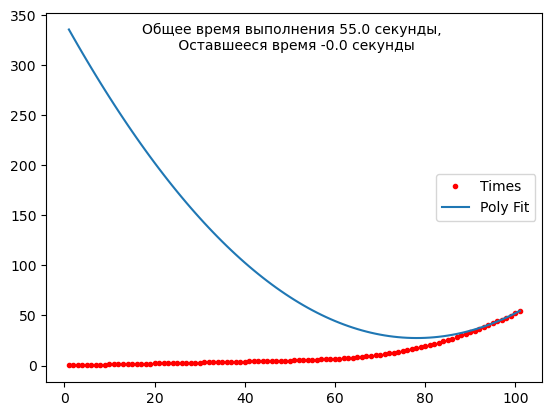

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:54<00:00,  1.85it/s]


In [380]:
photon_number_dynamics = mp.calculate_photon_number_in_set_of_solutions(set_of_solutions, n1, n2, x_left, x_bond2, step1_v1, step2, x_bias, solver=mp.calculate_photon_number3, step=400)

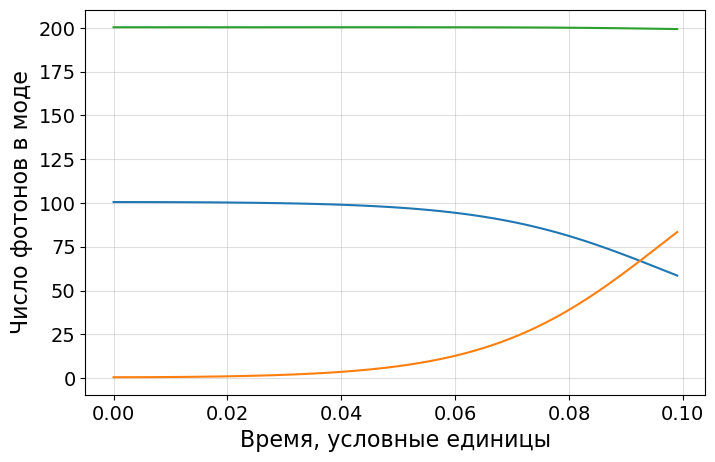

In [381]:
fig, ax1 = plt.subplots(figsize = (8,5))
plt.grid(alpha=0.4)
ax1.set_xlabel("Время, условные единицы", fontsize = 16)
ax1.set_ylabel("Число фотонов в моде", fontsize = 16)
line1, = ax1.plot(np.arange(len(photon_number_dynamics[0][:-1]))*0.001, np.array(photon_number_dynamics[0][:-1]), label = "Photons in pump mode (tensor networks)")
line2, = ax1.plot(np.arange(len(photon_number_dynamics[0][:-1]))*0.001, photon_number_dynamics[1][:-1], label = "Photons in signal mode (tensor networks)")
line3, = ax1.plot(np.arange(len(photon_number_dynamics[0][:-1]))*0.001, 2*np.array(photon_number_dynamics[0][:-1]) + np.array(photon_number_dynamics[1][:-1])-1.2, label = "Total energy of the system in the number of photons")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax1.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('photon_dynamics.png', bbox_inches='tight')
plt.show()

In [221]:
g = 0
k = -10
for i in set_of_solutions[k]:
    print(i.shape)

(1, 2, 1)
(1, 2, 2)
(2, 2, 3)
(3, 2, 4)
(4, 2, 6)
(6, 2, 6)
(6, 2, 5)
(5, 2, 4)
(4, 2, 4)
(4, 2, 3)
(3, 2, 3)
(3, 2, 3)
(3, 2, 6)
(6, 2, 6)
(6, 2, 6)
(6, 2, 6)
(6, 2, 8)
(8, 2, 8)
(8, 2, 7)
(7, 2, 6)
(6, 2, 5)
(5, 2, 4)
(4, 2, 2)
(2, 2, 1)


In [224]:
reddm1 = mp.find_reduced_density_matrix2(set_of_solutions[g], 1, n2, 0)
reddm2 = mp.find_reduced_density_matrix2(set_of_solutions[k], 1, n2, 0)
reddm1 = reddm1 / np.trace(reddm1)
reddm2 = reddm2 / np.trace(reddm2)

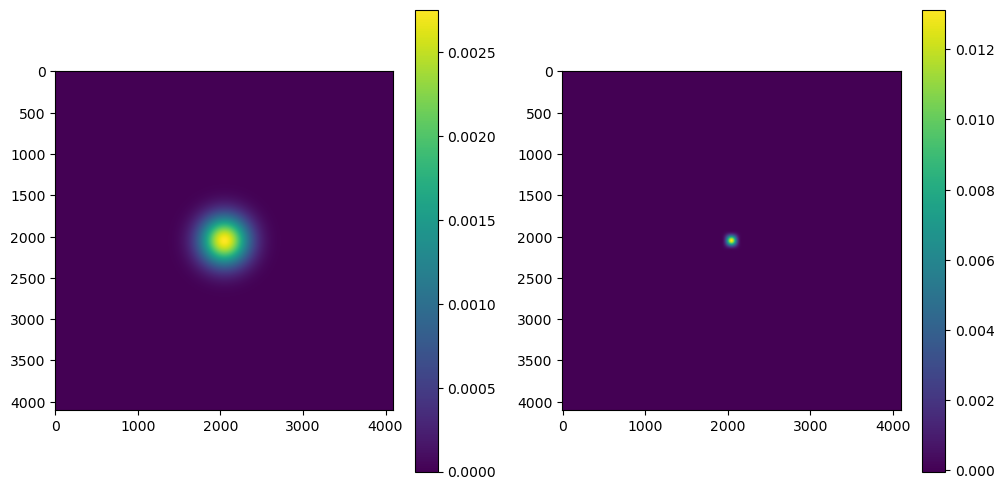

In [225]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
im1 = ax1.imshow(np.real(reddm1))
im2 = ax2.imshow(np.real(reddm2))
#ax1.text(1.35, 1.27, f'Матрица плотности моды сигнала в ходе эволюции под дейсвтием гамильтониана SPDC, \n вычисленная двумя разными методами и представленная в непрерывном представлении', transform=ax1.transAxes, ha='center')
#ax1.text(0.5, 1.05, f'Матрица плотности моды сигнала, \n вычисленная в координатном представлении \n с помощью тензорных сетей', transform=ax1.transAxes, ha='center')
#ax1.text(0.1, 0.9, f't={num_iter}', color = 'white', transform=ax1.transAxes, ha='center')
#ax2.text(0.5, 1.05, f'Матрица плотности моды сигнала, \n вычисленная в Фоковском базисе \n и переведенная в координатное представление', transform=ax2.transAxes, ha='center')
#ax2.text(0.1, 0.9, f't={num_iter}', color = 'white', transform=ax2.transAxes, ha='center')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

# plt.imshow(np.real(reddm2))
# plt.colorbar()
# plt.show()

## Рунге-Кутта 2го порядка для задачи сжатия

### Дифференциальная задача в общем виде

$\dfrac{dy}{dt} = f(t,y)$

### Формула метода Рунге-Кутта

$y_{n+1} = y_n + hf(t_n+\dfrac{1}{2}h, y_n+\dfrac{1}{2}hf(t_n,y_n))$

### Гамильтониан сжатия

$\hat{H} = i \alpha \dfrac{\hat{a}^2-(\hat{a}^\dagger)^2}{2} = i \alpha (x \dfrac{d}{dx} + 1/2)$

### Уравнение Шредингера

$i \dfrac{d\psi}{dt} = \hat{H}\psi$

### Система уравнений при решении методом Эйлера

$(I - i\Delta t \hat{H})\psi_{t+1}(x) - \psi_t(x) = 0$

$U \equiv (I - i\Delta t \hat{H}) = I + \alpha \Delta t (x \dfrac{d}{dx} + 1/2)$

### Правая часть дифференциального уравнения

$f(t,y) = -i\hat{H}\psi$

In [94]:
n = 8
alpha = 1
t_general = 1
steps_number = 55
delta_t = t_general/steps_number
x = np.linspace(-6, 6, 2**n)

$operator = -i\hat{H} = \alpha (x \dfrac{d}{dx} + 1/2)$

In [95]:
operator = mp.mpo_mul_num(mp.mpo_sum(mp.mpo_multiplication(mp.x_mpo(n, x[0], x[1]-x[0]), mp.der_mpo(n, x[1]-x[0])), mp.chislo(n, 0.5)), alpha)

In [96]:
psi_0 = mp.vec_to_mps(mp.squeezed_vacuum(x, 1, 0))
psi_final = mp.vec_to_mps(mp.squeezed_vacuum(x, 1, 1))

In [97]:
# plt.plot(mp.squeezed_vacuum(x, 1, 0))
# plt.show()

In [98]:
def make_squeezing_step(psi, delta_t):
    k = mp.mps_sum(psi, mp.mps_mul_num(mp.mpo_x_mps(operator, psi), 0.5*delta_t))
    return mp.mps_sum(psi, mp.mps_mul_num(mp.mpo_x_mps(operator, k), delta_t))

In [99]:
psi = make_squeezing_step(psi_0, delta_t)
psi = mp.mps_compression(psi)
for i in tqdm(range(steps_number)):
    psi = make_squeezing_step(psi, delta_t)
    psi = mp.mps_compression(psi)

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 65.95it/s]


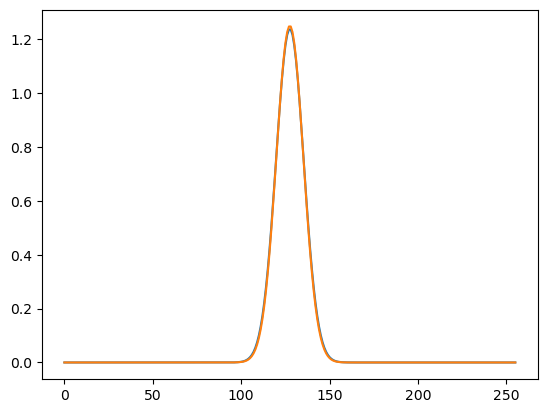

In [100]:
plt.plot(mp.squeezed_vacuum(x, 1, 1))
plt.plot(mp.tensors_multiplication(psi))
plt.show()

### Рунге-Кутта 2го порядка для SPDC

$operator = -i\hat{H} = \dfrac{\chi^{(2)}}{\sqrt{2}}(\dfrac{d}{dx_a}(\hat{x}_b^2 + \dfrac{d^2}{dx_b^2}) - \hat{x}_a(\hat{1}_b + 2\hat{x}_b\dfrac{d}{dx_b}))$

In [10]:
chi = 1 / 2
theta = 0.001

t_general = 0.9
steps_number = 90000
delta_t = t_general / steps_number

x_bond1 = 30

x_left = 10 + 2 * 10 * np.sqrt(2)
x_right = 10

x_bond2 = 10
n1 = 10
n2 = 10
x_bias = 10 * np.sqrt(2)
step1 = x_bond1 / 2**(n1 - 1)
step2 = x_bond2 / 2**(n2 - 1)

eps = 1e-6

sp2 = np.linspace(-10,10,2**n2)
step2 = sp2[1]-sp2[0]

sp1 = np.linspace(-10-10*np.sqrt(2),10+10*np.sqrt(2),2**n1)
step1_v1 = sp1[1]-sp1[0]

In [11]:
coh_operator_one = mp.der_mpo(n1, step1_v1)
coh_operator_two = mp.mpo_mul_num(mp.x_mpo(n1, x_bias - x_left, step1_v1), -1)
vac_operator_one = mp.mpo_sum(mp.mpo_multiplication(mp.x_mpo(n2, - x_bond2, step2), mp.x_mpo(n2, - x_bond2, step2)), mp.der2_mpo(n2, step2))
vac_operator_two = mp.mpo_sum(mp.one_mpo(n2), mp.mpo_mul_num(mp.mpo_multiplication(mp.x_mpo(n2, - x_bond2, step2), mp.der_mpo(n2, step2)), 2))
first_part = coh_operator_one + vac_operator_one
second_part = coh_operator_two + vac_operator_two
operator = mp.mpo_mul_num(mp.mpo_sum(first_part, second_part), -chi / (np.sqrt(2)))

In [12]:
def make_SPDC_step(psi, delta_t, eps = 1e-6, bond_limit = 1000):
    k = mp.mps_sum(psi, mp.mps_mul_num(mp.mps_compression(mp.mpo_x_mps(operator, psi), eps=eps, bond_limit=bond_limit), 0.5*delta_t))
    return mp.mps_compression(mp.mps_sum(psi, mp.mps_mul_num(mp.mps_compression(mp.mpo_x_mps(operator, k), eps=eps, bond_limit=bond_limit), delta_t)), eps=eps, bond_limit=bond_limit)

In [13]:
initial_state_mps = mp.asym_gauss_mps(x_left, x_right, n1, 1) + mp.asym_gauss_mps(x_bond2, x_bond2, n2, 1)

In [21]:
set_of_solutions = []
set_of_solutions.append(initial_state_mps)
psi = make_SPDC_step(initial_state_mps, delta_t, eps=1e-5, bond_limit=60)
set_of_solutions.append(psi)
for i in tqdm(range(steps_number)):
    psi = make_SPDC_step(psi, delta_t, eps=1e-5, bond_limit=60)
    set_of_solutions.append(psi)

100%|█████████████████████████████████████████████████████████████████████████| 90000/90000 [31:23:06<00:00,  1.26s/it]


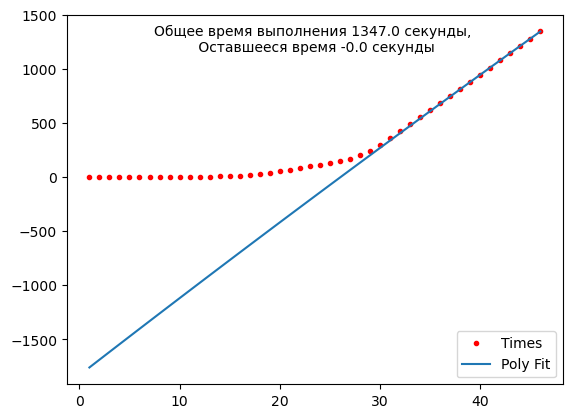

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [22:26<00:00, 29.28s/it]


In [22]:
photon_number_dynamics = mp.calculate_photon_number_in_set_of_solutions(set_of_solutions, n1, n2, x_left, x_bond2, step1_v1, step2, x_bias, solver=mp.calculate_photon_number3, step=2000)

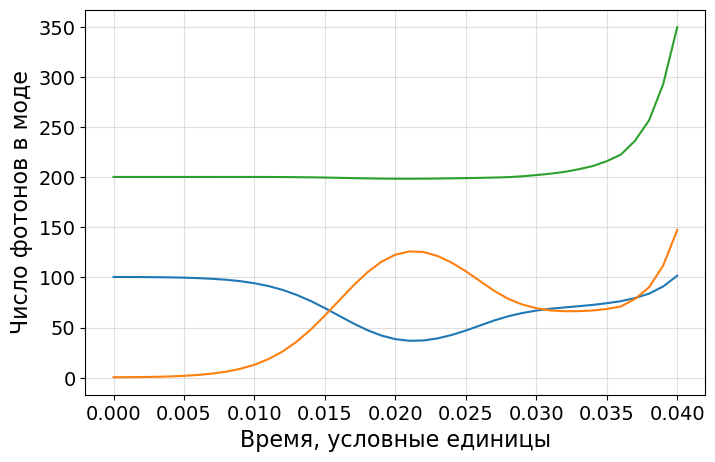

In [24]:
fig, ax1 = plt.subplots(figsize = (8,5))
plt.grid(alpha=0.4)
ax1.set_xlabel("Время, условные единицы", fontsize = 16)
ax1.set_ylabel("Число фотонов в моде", fontsize = 16)
line1, = ax1.plot(np.arange(len(photon_number_dynamics[0][:-5]))*0.001, np.array(photon_number_dynamics[0][:-5]), label = "Photons in pump mode (tensor networks)")
line2, = ax1.plot(np.arange(len(photon_number_dynamics[0][:-5]))*0.001, photon_number_dynamics[1][:-5], label = "Photons in signal mode (tensor networks)")
line3, = ax1.plot(np.arange(len(photon_number_dynamics[0][:-5]))*0.001, 2*np.array(photon_number_dynamics[0][:-5]) + np.array(photon_number_dynamics[1][:-5])-1.2, label = "Total energy of the system in the number of photons")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax1.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('photon_dynamics.png', bbox_inches='tight')
plt.show()

In [120]:
g = 0
k = 70000

In [123]:
reddm1 = mp.find_reduced_density_matrix2(set_of_solutions[g], 0, n1, 0)
reddm2 = mp.find_reduced_density_matrix2(set_of_solutions[k], 0, n1, 0)
reddm1 = reddm1 / np.trace(reddm1)
reddm2 = reddm2 / np.trace(reddm2)

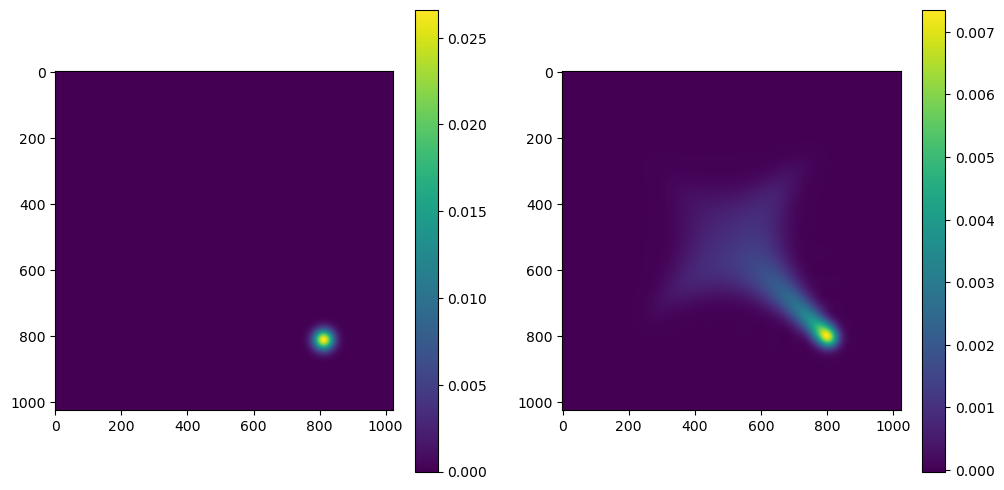

In [124]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
im1 = ax1.imshow(np.real(reddm1))
im2 = ax2.imshow(np.real(reddm2))
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()